# MARKETING CAMPAIGNS AND SALES PREDICTIONS

In [1]:
!pip install pydot

In [307]:
import random
import itertools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pydot
import seaborn as sns
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [308]:
%matplotlib inline

In [309]:
random_seed = 54
np.random.seed(random_seed)
random.seed(random_seed)

In [310]:
FILE_SOURCE = 'marketing_campaigns.csv'

## 1. DATA PREPROCESSING

### Loading data

In [311]:
def load_data(file):
    return pd.read_csv(file)

In [353]:
df_marketing_sales = load_data(FILE_SOURCE)

In [354]:
df_marketing_sales.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [355]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Sales
count,4562.000000,4568.000000,4566.000000,4566.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.125054,9.676958,2.212670,93.133092
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.525957,1.527849,112.322882
50%,53.000000,17.859513,3.055565,189.231172
75%,77.000000,25.649730,4.807558,272.507922
max,100.000000,48.871161,13.981662,364.079751


In [356]:
df_marketing_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


### Null values treatment

In [357]:
# Numero de valores nulos
df_marketing_sales.isna().sum(axis=0)

TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64

In [358]:
# Porcentaje de valores nulos por campo
df_marketing_sales.isna().sum(axis=0)*100/df_marketing_sales.shape[0]

TV              0.218723
Radio           0.087489
Social Media    0.131234
Influencer      0.000000
Sales           0.131234
dtype: float64

In [359]:
# Primera aproximacion: eliminar los valores nulos

# Eliminando los valores nulos que porcentaje de datos nos quedaria
df_marketing_sales.dropna().shape[0] * 100 / df_marketing_sales.shape[0]

# No quedariamos con el 99% de los datos no estaria mal, podemos elinarlos

99.4313210848644

In [360]:
# Segunda aproximacion: sustitucion de valores

df_marketing_sales['TV'] = df_marketing_sales['TV'].fillna(df_marketing_sales['TV'].mean())
df_marketing_sales['Radio'] = df_marketing_sales['Radio'].fillna(df_marketing_sales['Radio'].mean())
df_marketing_sales['Social Media'] = df_marketing_sales['Social Media'].fillna(df_marketing_sales['Social Media'].mean())
df_marketing_sales['Influencer'] = df_marketing_sales['Influencer'].fillna(df_marketing_sales['Influencer'].mode())
df_marketing_sales['Sales'] = df_marketing_sales['Sales'].fillna(df_marketing_sales['Sales'].mean())

In [361]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Sales
count,4572.000000,4572.000000,4572.000000,4572.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.096461,9.672723,2.211218,93.071947
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.546519,1.529879,112.397660
50%,53.000000,17.875181,3.057150,189.632530
75%,77.000000,25.647476,4.805832,272.414914
max,100.000000,48.871161,13.981662,364.079751


In [362]:
df_marketing_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4572 non-null   float64
 1   Radio         4572 non-null   float64
 2   Social Media  4572 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4572 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


### Encoding data

In [363]:
# Datos categoricos
df_marketing_sales['Influencer'].unique()

array(['Mega', 'Micro', 'Nano', 'Macro'], dtype=object)

In [364]:
# Hay una relacion de orden
df_marketing_sales_notcod = df_marketing_sales.copy()
df_marketing_sales['Influencer'] = df_marketing_sales['Influencer'].map({
    'Macro': 4,
    'Mega': 3,
    'Micro': 2,
    'Nano': 1
})

### Detecting outliers

Detección de outliers para atributos continuos

In [325]:
atributos_continuos = ['TV', 'Radio', 'Social Media', 'Sales']
atributos_categoricos = ['Influencer']

In [367]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Influencer,Sales
count,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000
mean,54.066857,18.160356,3.323956,2.494969,192.466602
std,26.096461,9.672723,2.211218,1.113243,93.071947
min,10.000000,0.000684,0.000031,1.000000,31.199409
25%,32.000000,10.546519,1.529879,2.000000,112.397660
50%,53.000000,17.875181,3.057150,2.000000,189.632530
75%,77.000000,25.647476,4.805832,3.000000,272.414914
max,100.000000,48.871161,13.981662,4.000000,364.079751


In [327]:
def remove_outliers_IQR(df,df_column,otype):
    # Calculamos el rango intercuartilico
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    # Detectamos indices de los outliers
    df2 = None
    if otype=="up":
        df2 = df[~(df_column > (Q3 + 1.5 * IQR))]
    elif otype=="down":
        df2 = df[~(df_column < (Q1 - 1.5 * IQR))]
    elif otype=="both":
        df2 = df[~(df_column < (Q1 - 1.5 * IQR)) | (df_column > (Q3 + 1.5 * IQR))]
    else:
        df2 = df
    return df2

<Axes: >

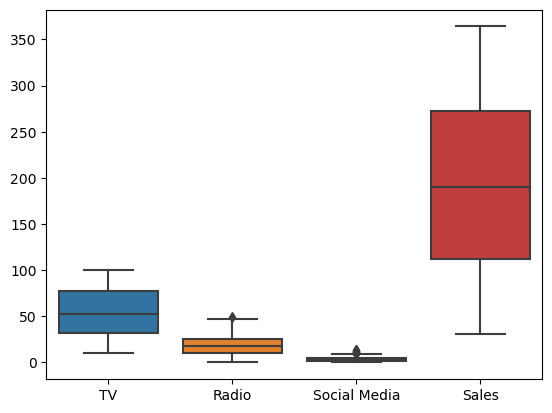

In [328]:
# Deteccion de outliers mediante boxplot como herramienta de estadistica
# descriptiva

sns.boxplot(data=df_marketing_sales[atributos_continuos])

<Axes: >

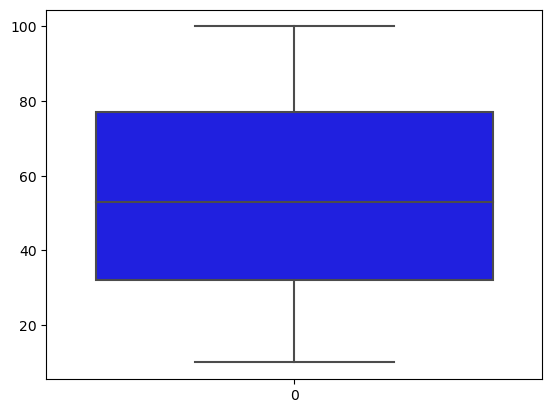

In [329]:
# Deteccion de outliers en el atributo TV

sns.boxplot(data=df_marketing_sales['TV'], color="b")
# No detectamos outliers

<Axes: >

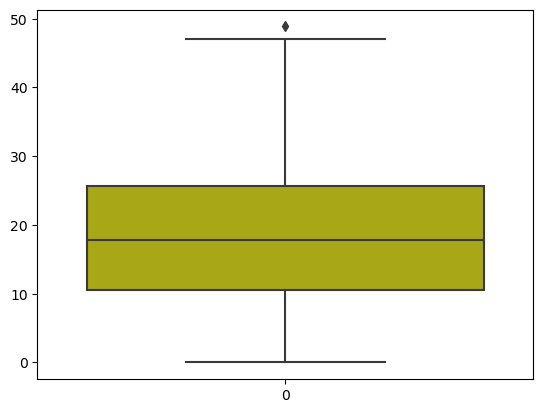

In [330]:
# Deteccion de outliers en el atributo Radio

sns.boxplot(data=df_marketing_sales['Radio'], color='y')
# Detectamos outliers superiores

In [331]:
# Eliminacion de outliers de Radio

print(df_marketing_sales.shape, remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Radio'],"up").shape)

df_marketing_sales = remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Radio'],"up")
df_marketing_sales

(4572, 5) (4571, 5)


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


<Axes: >

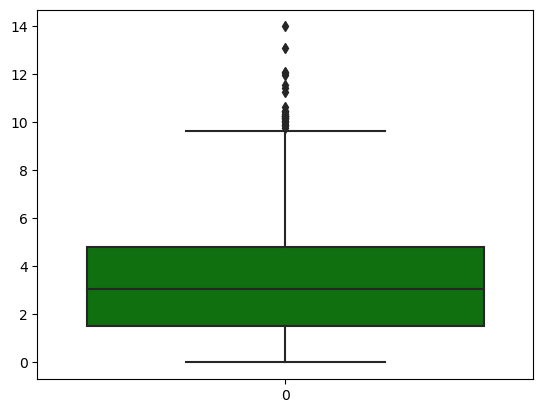

In [332]:
# Deteccion de outliers en el atributo Social Media

sns.boxplot(data=df_marketing_sales['Social Media'], color='g')
# Detectamos outliers superiores

In [333]:
# Eliminacion de outliers de Social Media

print(df_marketing_sales.shape, remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Social Media'],"up").shape)

df_marketing_sales = remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Social Media'],"up")
df_marketing_sales

(4571, 5) (4543, 5)


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


<Axes: >

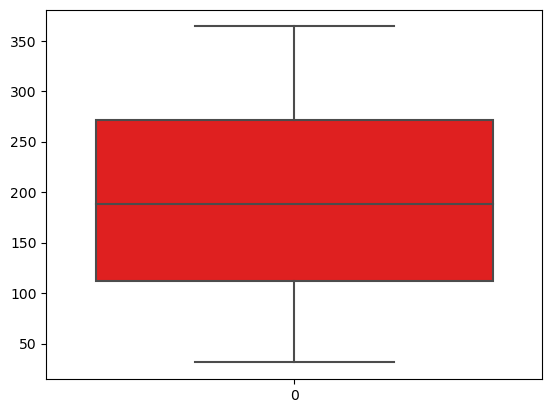

In [334]:
# Deteccion de outliers en el atributo Sales

sns.boxplot(data=df_marketing_sales['Sales'], color='r')
# No detectamos outliers

## 2. EXPLORATORY DATA ANALYSIS (EDA)

In [335]:
df_marketing_sales

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


### Budget study

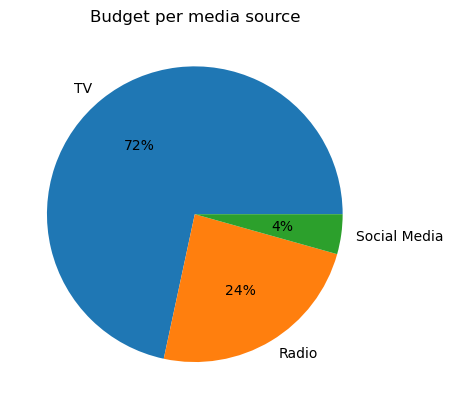

In [336]:
# Presupuesto total invertido en cada uno de los medios
# -------------------------------------------------------------

budget_per_source = df_marketing_sales.sum(axis=0)[['TV', 'Radio', 'Social Media']]
ax = budget_per_source.plot(kind='pie', autopct='%.0f%%')
ax.set_title('Budget per media source')
plt.show()

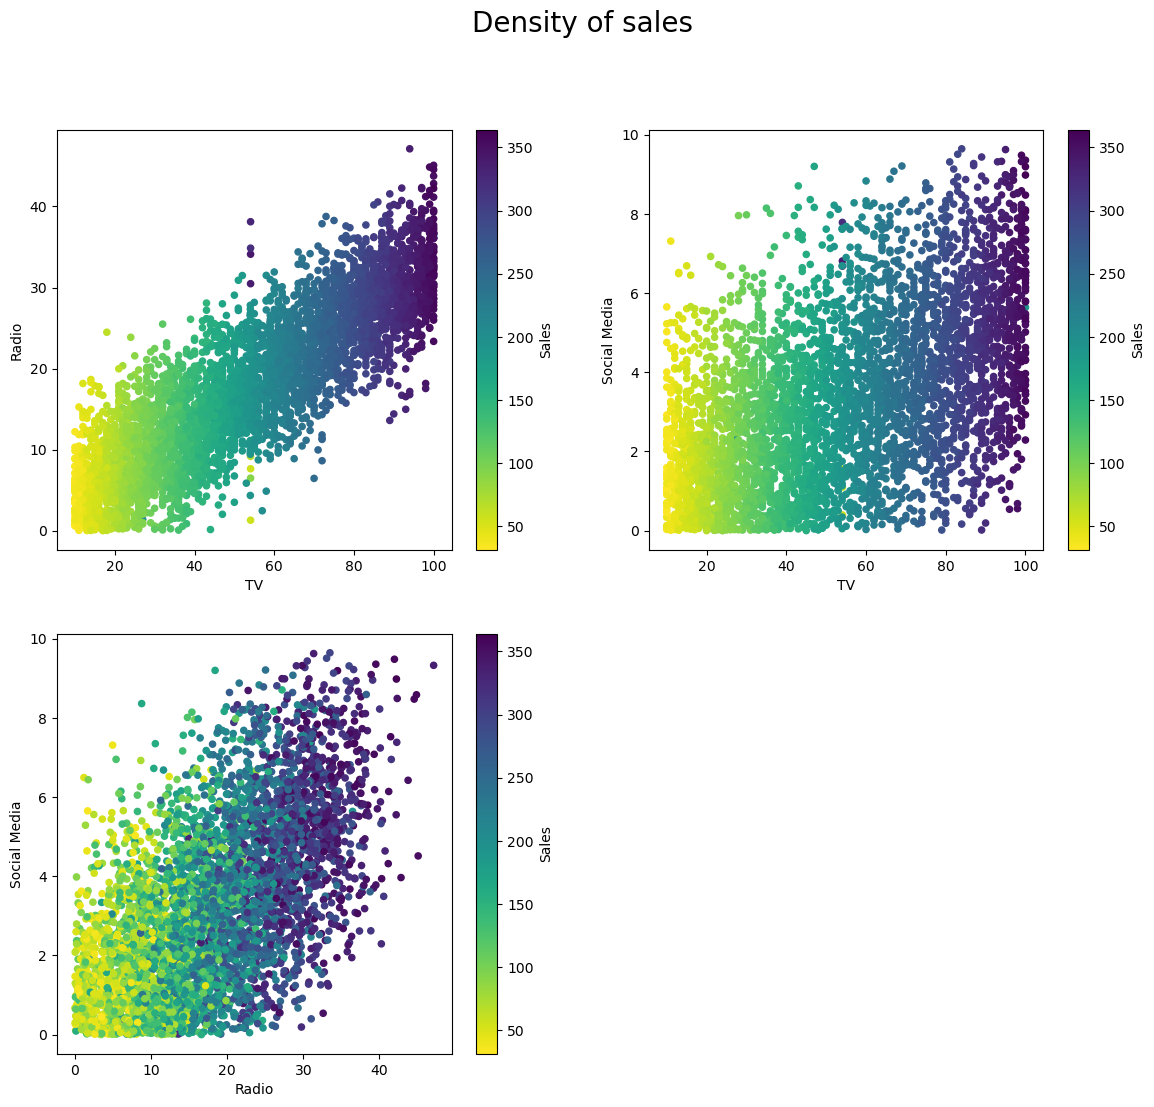

In [337]:
# Concentracion del numero de ventas en funcion del presupuesto en TV y Radio
# -----------------------------------------------------------------------

fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(14,12), gridspec_kw={
                             'wspace':0.2,
                             'hspace': 0.2})

fig.suptitle('Density of sales', fontsize=20)

df_marketing_sales.plot.scatter(x='TV',y='Radio',c='Sales',
                                colormap=matplotlib.colormaps['viridis'].reversed(),
                               ax=axes[0,0])
df_marketing_sales.plot.scatter(x='TV',y='Social Media',c='Sales',
                                colormap=matplotlib.colormaps['viridis'].reversed(),
                               ax=axes[0,1])
df_marketing_sales.plot.scatter(x='Radio',y='Social Media',c='Sales',
                                colormap=matplotlib.colormaps['viridis'].reversed(),
                               ax=axes[1,0])

for ax in axes.flat[3:]:
    ax.axis('off')

In [340]:
# Tipo de influencer mas contratado y ventas por tipo de influencer
# -----------------------------------------------------------------------

influencers_count = df_marketing_sales['Influencer'].value_counts().sort_index()
influencers_count.index = influencers_count.index.to_series().replace(
    {4:'Macro',3:'Mega',2:'Micro',1:'Nano'}
)
print("Number of times each influencer is hired")
display(influencers_count.to_frame())

influencers_sales = df_marketing_sales[['Influencer', 'Sales']].groupby('Influencer').sum()
influencers_sales.index = influencers_sales.index.to_series().replace(
    {4:'Macro',3:'Mega',2:'Micro',1:'Nano'}
)
print("Sales per influencer type")
display(influencers_sales)

Number of times each influencer is hired


,Influencer
Nano,1134
Micro,1148
Mega,1146
Macro,1115


Sales per influencer type


,Sales
Influencer,
Nano,217030.743272
Micro,219558.388385
Mega,217181.280706
Macro,217541.832701


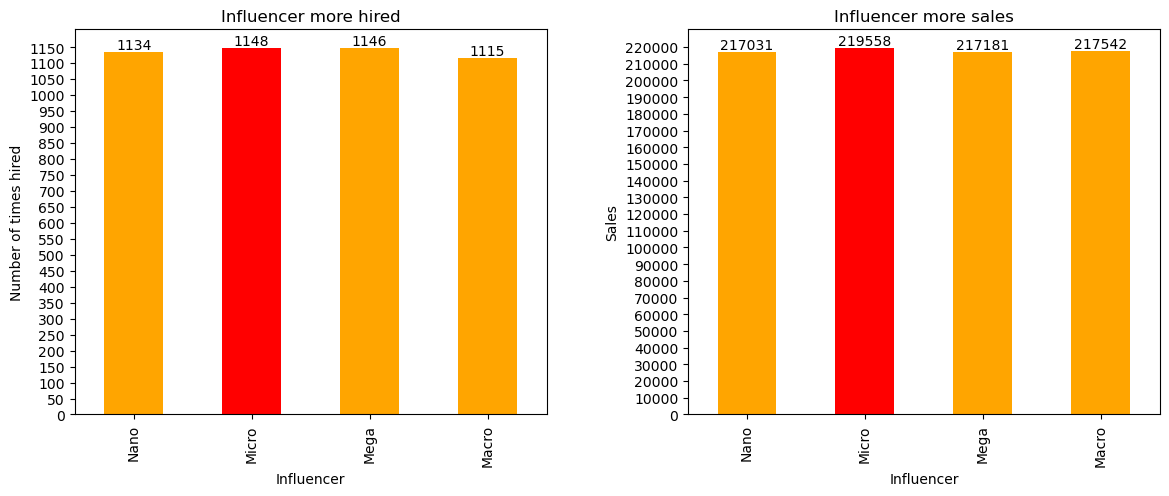

In [341]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(14,5), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

# Tipo de influencer mas contratado
influencers_count.plot.bar(
    color=['orange', 'red', 'orange', 'orange'], ax=axes[0]
)
for i in axes[0].containers:
    axes[0].bar_label(i, label_type='edge')
    
axes[0].set_yticks(np.arange(0,1151,50))
axes[0].set_xlabel('Influencer')
axes[0].set_ylabel('Number of times hired')
axes[0].set_title('Influencer more hired')

# Total de ventas por tipo de influencer
influencers_sales.squeeze().plot.bar(
    color=['orange', 'red', 'orange', 'orange'], ax=axes[1]
)
for i in axes[1].containers:
    axes[1].bar_label(i, label_type='edge')

axes[1].set_yticks(np.arange(0,220001,10000))
axes[1].set_ylabel('Sales')
axes[1].set_title('Influencer more sales')

plt.show()

In [342]:
# Presupuesto invertido en los distintos medios segun el medio y el influencer 
# que representa la campaña
# -----------------------------------------------------------------------

budget_table_influencer_media = df_marketing_sales.groupby(['Influencer']).sum()
budget_table_influencer_media.index = budget_table_influencer_media.index.to_series().replace(
    {4:'Macro',3:'Mega',2:'Micro',1:'Nano'}
)
budget_table_influencer_media

,TV,Radio,Social Media,Sales
Influencer,,,,
Nano,60949.066857,20349.470951,3685.443790,217030.743272
Micro,61638.133713,20842.970529,3719.746529,219558.388385
Mega,60963.133713,20535.631428,3779.878510,217181.280706
Macro,61218.334283,20323.321763,3702.842384,217541.832701


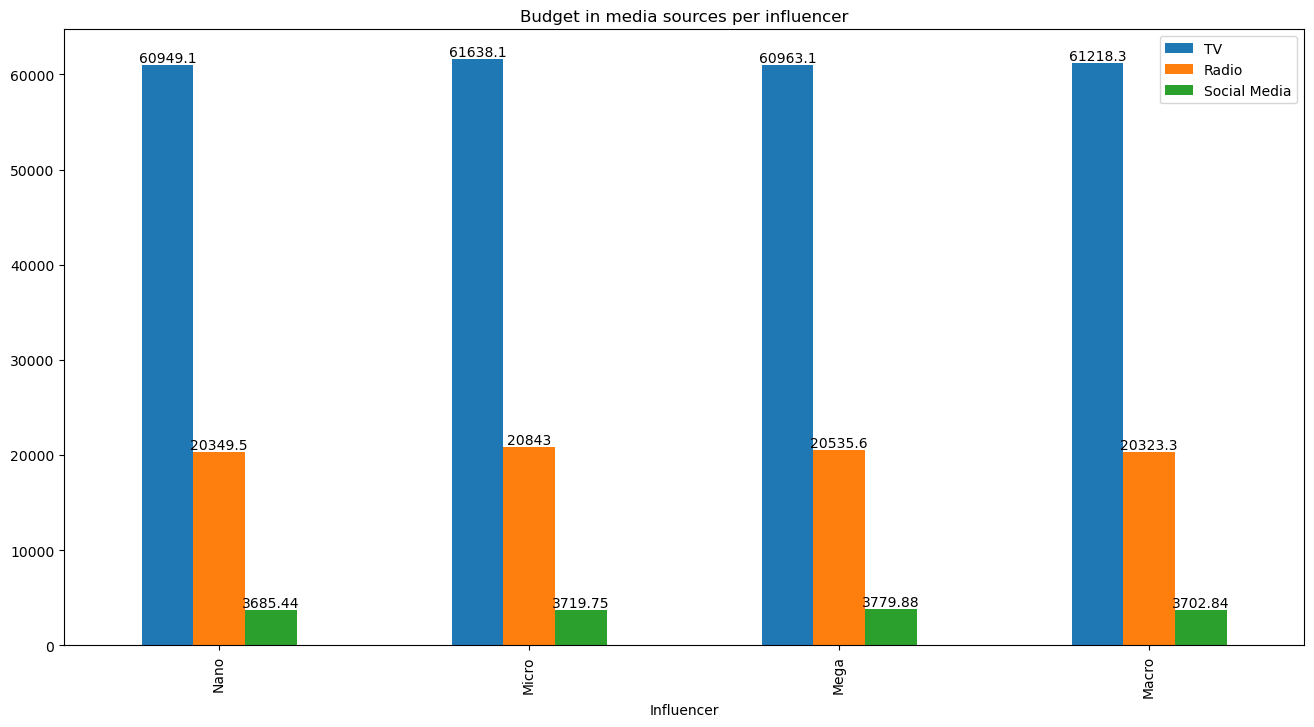

In [343]:
# Para cada tipo de influencer, inversion en cada medio
# -----------------------------------------------------------------------
ax = budget_table_influencer_media.drop('Sales', axis=1).plot.bar(figsize=(16,8))
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
ax.set_title('Budget in media sources per influencer')
plt.show()

# ----------------------------------------------------------
# Independientemente del tipo de influencer, la tendencia de inversion en
# los medios de comunicacion de mantiene: mayor inversion en TV, luego en Radio
# y luego en Social Media

In [344]:
# Con que influencer se ha invertido mas dinero en cada medio
# ------------------------------------------------------------
budget_table_influencer_media.transpose().idxmax(axis=1).to_frame(
    name='Influencer with more investment per media'
)

,Influencer with more investment per media
TV,Micro
Radio,Micro
Social Media,Mega
Sales,Micro


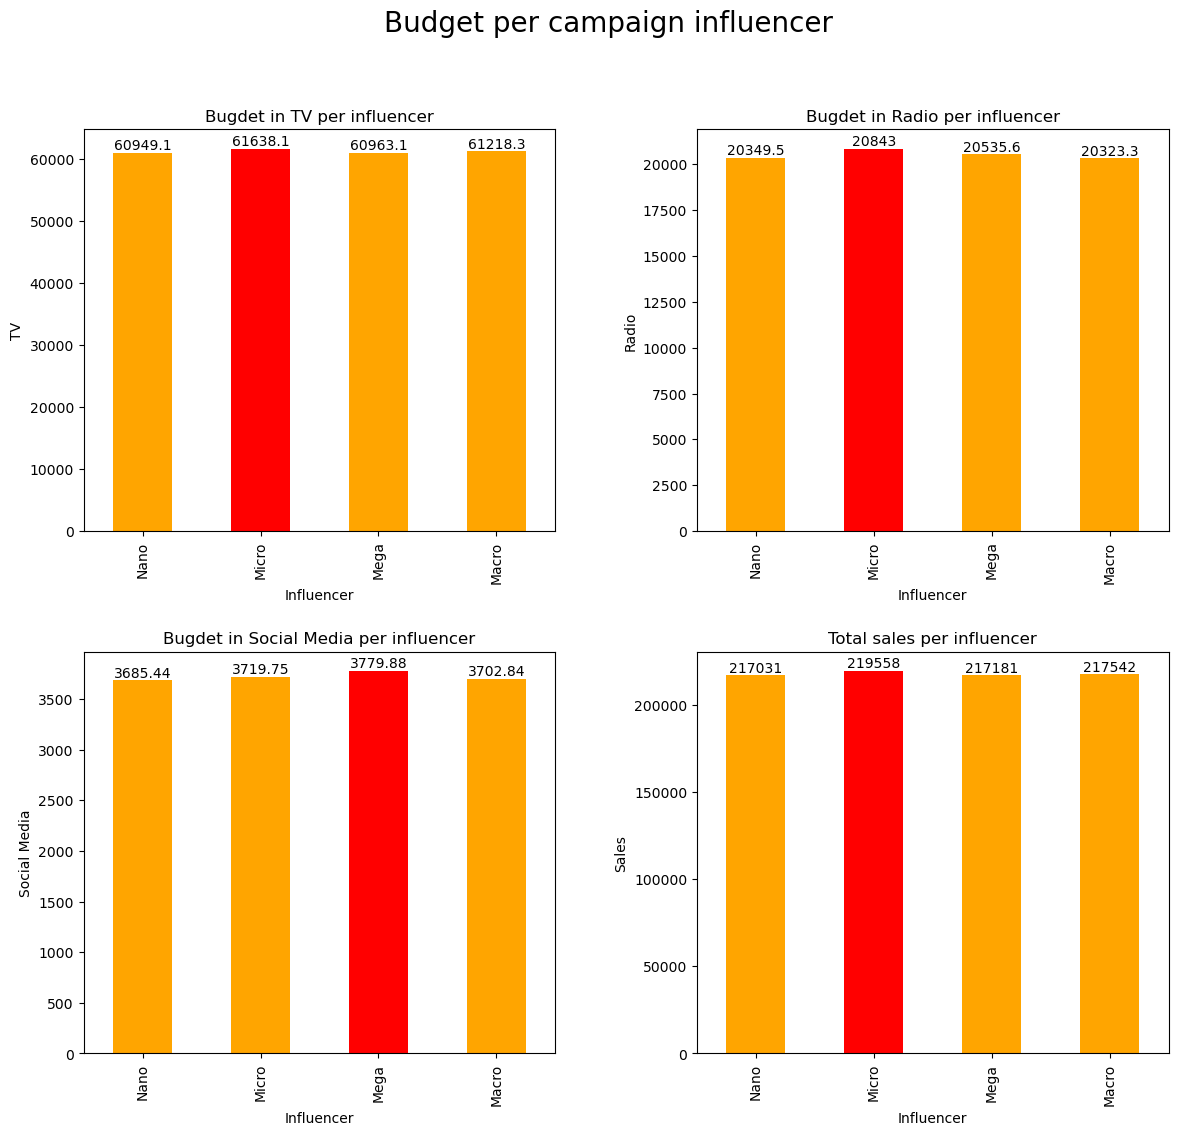

In [345]:
# Presupuesto invertido en los distintos medios segun el tipo de influencer
# que representa la campaña
# -----------------------------------------------------------------------

fig, axes = plt.subplots(nrows=2, ncols=2, 
                         figsize=(14,12), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

fig.suptitle('Budget per campaign influencer', fontsize=20)

axes[0,0].set_title('Bugdet in TV per influencer')
axes[0,0].set_ylabel('TV')
budget_table_influencer_media['TV'].plot.bar(ax=axes[0,0], 
                                             color=['orange', 'red', 'orange', 'orange'])
for i in axes[0,0].containers:
    axes[0,0].bar_label(i, label_type='edge')

    
axes[0,1].set_title('Bugdet in Radio per influencer')
axes[0,1].set_ylabel('Radio')
budget_table_influencer_media['Radio'].plot.bar(ax=axes[0,1],
                                                color=['orange', 'red', 'orange', 'orange']
    )
for i in axes[0,1].containers:
    axes[0,1].bar_label(i, label_type='edge')
   

axes[1,0].set_title('Bugdet in Social Media per influencer')
axes[1,0].set_ylabel('Social Media')
budget_table_influencer_media['Social Media'].plot.bar(ax=axes[1,0],
                                                      color=['orange', 'orange', 'red', 'orange'])
for i in axes[1,0].containers:
    axes[1,0].bar_label(i, label_type='edge')

    
axes[1,1].set_title('Total sales per influencer')
axes[1,1].set_ylabel('Sales')
budget_table_influencer_media['Sales'].plot.bar(ax=axes[1,1],
                                               color=['orange', 'red', 'orange', 'orange'])
for i in axes[1,1].containers:
    axes[1,1].bar_label(i, label_type='edge')

# ----------------------------------------------------------
# Normalmente se apuesta mas por micro o mega influencers

### Feautures distribution

#### TV distribution

<Axes: xlabel='TV', ylabel='Count'>

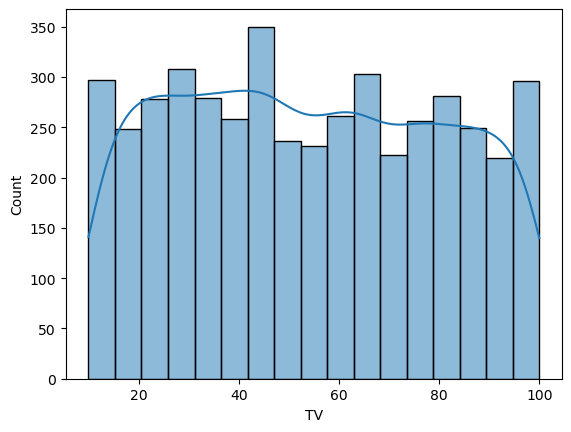

In [404]:
# Distribucion global del atributo TV
sns.histplot(data=df_marketing_sales_notcod, x='TV', kde=True)

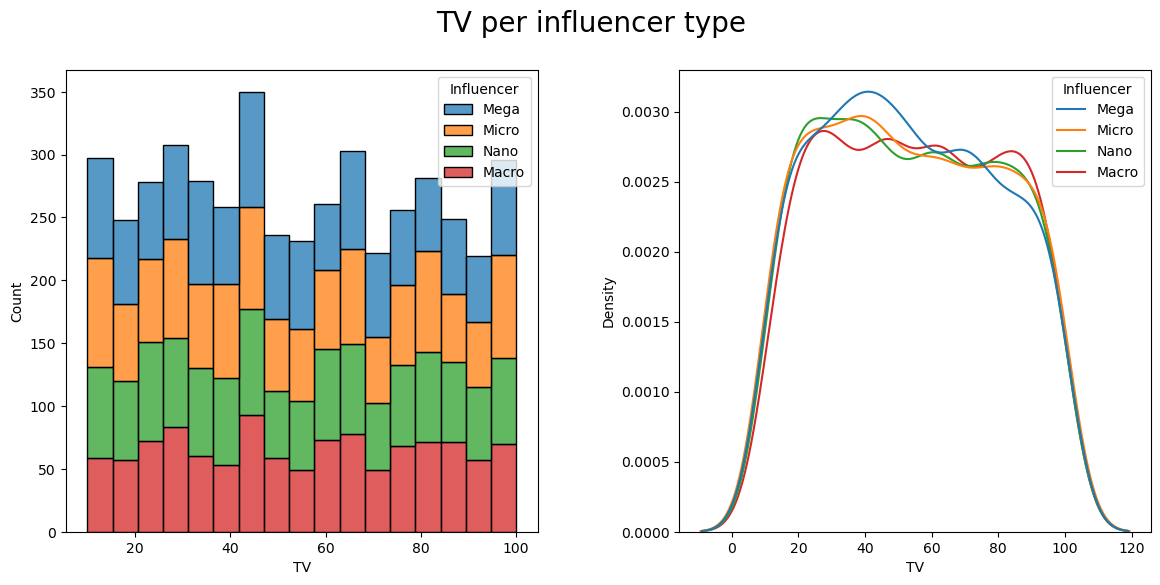

In [416]:
# Histograma de frecuencias según el tipo de influencer
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(14,6), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

fig.suptitle('TV per influencer type', fontsize=20)
sns.histplot(df_marketing_sales_notcod, x='TV', hue='Influencer', 
             multiple="stack", ax=axes[0])

sns.kdeplot(df_marketing_sales_notcod, x='TV', hue='Influencer', 
            ax=axes[1])
plt.show()

# ----------------------------------------------------
# Independientemente del tipo de influencer, el presupuesto en
# TV sigue sigue una distribucion similar

#### Radio distribution

<Axes: xlabel='Radio', ylabel='Count'>

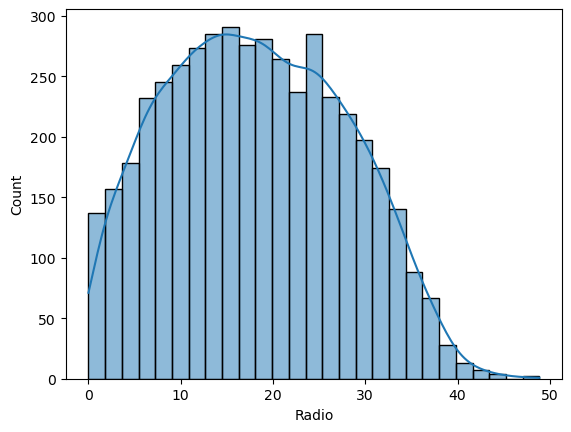

In [405]:
# Distribucion global del atributo Radio
sns.histplot(data=df_marketing_sales_notcod, x='Radio', kde=True)

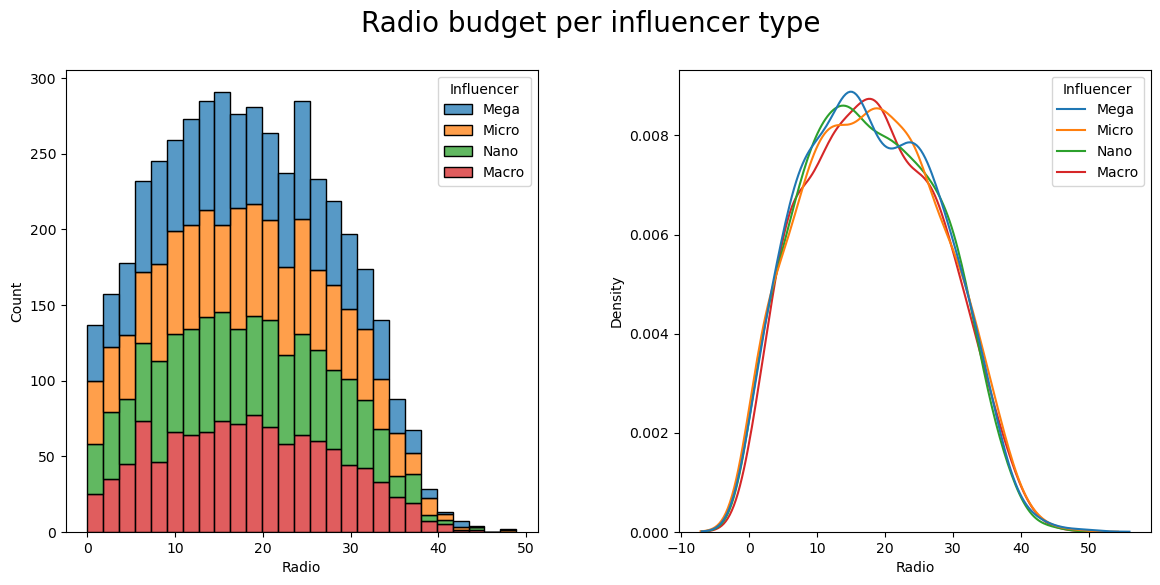

In [415]:
# Histograma de frecuencias según el tipo de influencer
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(14,6), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

fig.suptitle('Radio budget per influencer type', fontsize=20)
sns.histplot(df_marketing_sales_notcod, x='Radio', hue='Influencer', 
             multiple="stack", ax=axes[0])

sns.kdeplot(df_marketing_sales_notcod, x='Radio', hue='Influencer', 
            ax=axes[1])
plt.show()
# ------------------------------------------------------
# Independientemente del tipo de influencer, el presupuesto en
# Radio sigue sigue una distribucion similar

#### Social Media distribution

<Axes: xlabel='Social Media', ylabel='Count'>

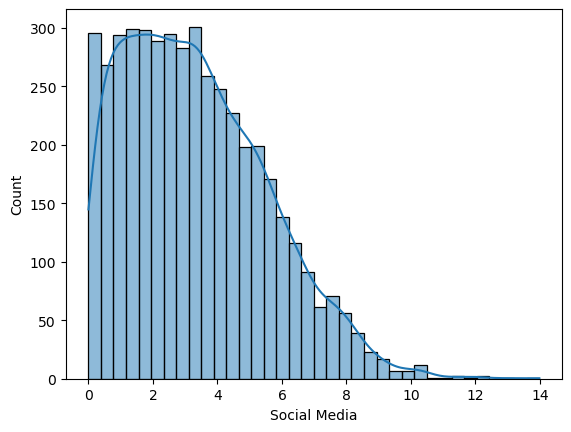

In [407]:
# Distribucion global del atributo Social Media
sns.histplot(data=df_marketing_sales_notcod, x='Social Media', kde=True)

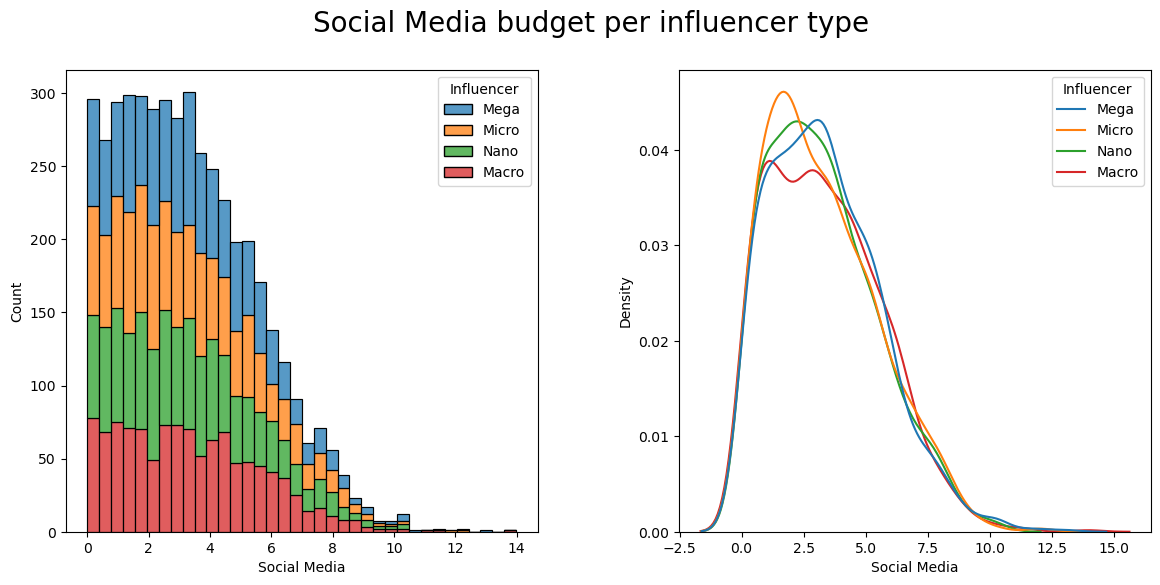

In [414]:
# Histograma de frecuencias según el tipo de influencer
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(14,6), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

fig.suptitle('Social Media budget per influencer type', fontsize=20)
sns.histplot(df_marketing_sales_notcod, x='Social Media', hue='Influencer', 
             multiple="stack", ax=axes[0])

sns.kdeplot(df_marketing_sales_notcod, x='Social Media', hue='Influencer', 
            ax=axes[1])
plt.show()
# ------------------------------------------------------
# Independientemente del tipo de influencer, el presupuesto en
# Social Media sigue una distribucion similar

#### Sales distribution

<Axes: xlabel='Sales', ylabel='Count'>

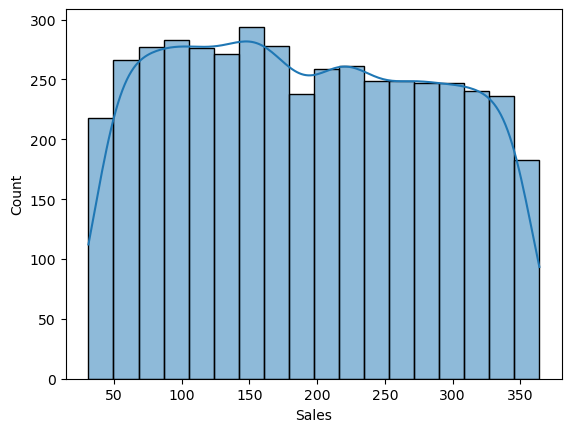

In [409]:
# Distribucion global del atributo Social Media
sns.histplot(data=df_marketing_sales_notcod, x='Sales', kde=True)

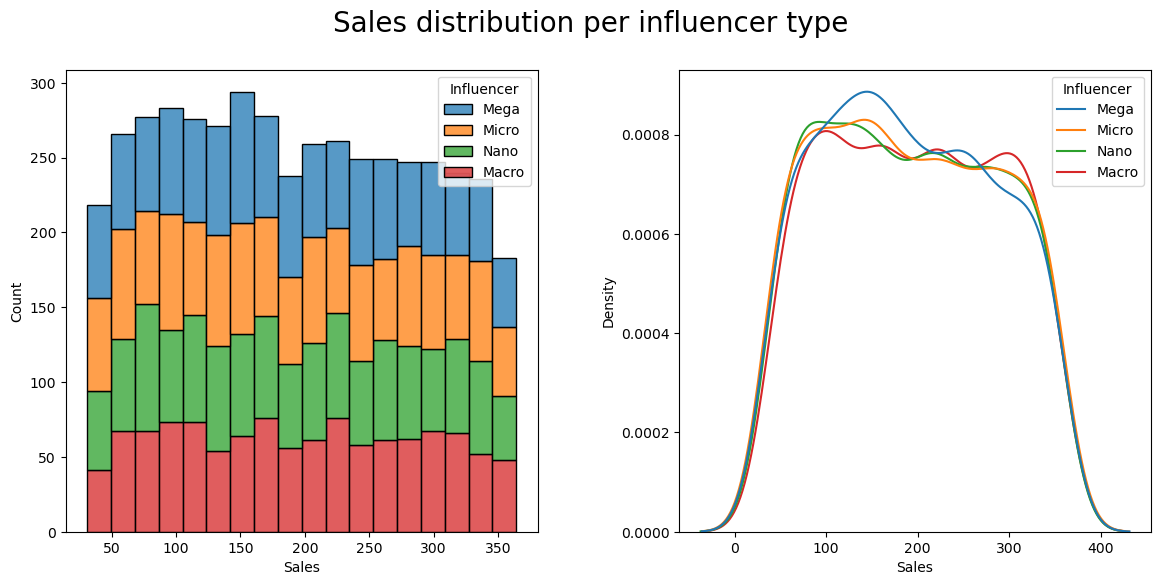

In [413]:
# Histograma de frecuencias según el tipo de influencer
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(14,6), gridspec_kw={
                             'wspace':0.3,
                             'hspace': 0.3})

fig.suptitle('Sales distribution per influencer type', fontsize=20)
sns.histplot(df_marketing_sales_notcod, x='Sales', hue='Influencer', 
             multiple="stack", ax=axes[0])

sns.kdeplot(df_marketing_sales_notcod, x='Sales', hue='Influencer', 
            ax=axes[1])
plt.show()
# ------------------------------------------------------
# Independientemente del tipo de influencer, el presupuesto en
# Sales sigue una distribucion similar

### Features correlation

In [29]:
corr_matrix = df_marketing_sales.corr()
corr_matrix

,TV,Radio,Social Media,Influencer,Sales
TV,1.000000,0.866309,0.525166,0.012566,0.996622
Radio,0.866309,1.000000,0.600406,0.006991,0.866793
Social Media,0.525166,0.600406,1.000000,0.014139,0.526255
Influencer,0.012566,0.006991,0.014139,1.000000,0.011141
Sales,0.996622,0.866793,0.526255,0.011141,1.000000


<Axes: >

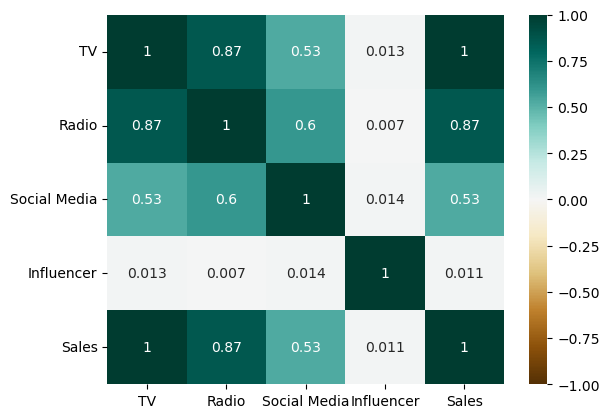

In [30]:
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='BrBG')

## 3. PREDICTING MODELS

In [31]:
X = df_marketing_sales.copy()

In [32]:
y = X.pop("Sales")

In [33]:
X

,TV,Radio,Social Media,Influencer
0,16.0,6.566231,2.907983,3
1,13.0,9.237765,2.409567,3
2,41.0,15.886446,2.913410,3
3,83.0,30.020028,6.922304,3
4,15.0,8.437408,1.405998,2
...,...,...,...,...
4567,26.0,4.472360,0.717090,2
4568,71.0,20.610685,6.545573,1
4569,44.0,19.800072,5.096192,2
4570,71.0,17.534640,1.940873,4


In [34]:
pd.DataFrame(y, columns=['Sales'])

,Sales
0,54.732757
1,46.677897
2,150.177829
3,298.246340
4,56.594181
...,...
4567,94.685866
4568,249.101915
4569,163.631457
4570,253.610411


In [35]:
# Hold out
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=random_seed)

In [36]:
# Particiones para cross validation
kfold = KFold(n_splits=10,shuffle=True, random_state=random_seed)
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    print("\nPartition number",i)
    print("----------------------")
    print("Train rows indexs:", train_index)
    print("Test rows indexs:", test_index)


Partition number 0
----------------------
Train rows indexs: [   0    4    5 ... 4540 4541 4542]
Test rows indexs: [   1    2    3   20   33   41   56   76   84   88   90  102  103  107
  112  122  146  150  155  159  163  164  177  192  232  242  247  251
  257  266  277  284  286  294  297  298  309  328  354  355  356  367
  369  370  379  381  391  406  430  431  437  441  457  477  482  492
  504  516  531  542  549  558  599  601  602  604  607  610  613  620
  634  635  641  642  645  650  682  692  697  698  705  708  732  741
  744  763  771  784  797  810  811  826  834  860  861  871  879  880
  881  901  917  925  956  961  963  969 1002 1021 1035 1036 1037 1069
 1093 1096 1109 1127 1133 1135 1147 1148 1150 1167 1170 1179 1180 1181
 1204 1210 1227 1234 1237 1242 1244 1245 1247 1255 1269 1279 1294 1301
 1303 1311 1325 1327 1328 1345 1346 1351 1362 1372 1376 1385 1409 1450
 1468 1478 1485 1518 1522 1525 1542 1543 1551 1563 1568 1603 1613 1618
 1627 1632 1660 1664 1679 1684 1

### Linear Regression

In [37]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

In [38]:
lreg.predict(X_test)

array([ 93.25193049, 354.9304834 , 163.60513626, ..., 206.6551706 ,
        39.30774411,  85.08929731])

In [39]:
print("Modelo lineal obtenido: \nsales = {:.2f} + {:.2f} * TV + {:.2f} * Radio + {:.2f} * SocialMedia + {:.2f} * Influencer".
      format(
    lreg.intercept_, 
    lreg.coef_.tolist()[0],
    lreg.coef_.tolist()[1],
    lreg.coef_.tolist()[2],
    lreg.coef_.tolist()[3]
) )

Modelo lineal obtenido: 
sales = 0.58 + 3.51 * TV + 0.11 * Radio + 0.06 * SocialMedia + -0.10 * Influencer


In [40]:
lreg.coef_.tolist()[0]

3.512439618630776

In [41]:
# Evaluando la bondad del modelo
print("Rendimiento (R^2) sobre entrenamiento: {:.2f}".format(lreg.score(X_train, y_train)))
print("Rendimiento (R^2) sobre test: {:.2f}".format(lreg.score(X_test, y_test)))
scores_val = cross_val_score(lreg, X, y, cv=kfold)
print("Rendimiento (R^2 medio) sobre validacion cruzada: {:.2f}".format(scores_val.mean()))

Rendimiento (R^2) sobre entrenamiento: 0.99
Rendimiento (R^2) sobre test: 0.99
Rendimiento (R^2 medio) sobre validacion cruzada: 0.99


In [42]:
# Otras metricas del modelo
mse = mean_squared_error(y_test, lreg.predict(X_test))
rmse = mean_squared_error(y_test, lreg.predict(X_test), squared=False)
r2 = r2_score(y_test, lreg.predict(X_test))
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2): {:.2f}".format(r2))

Mean Squared Error (MSE): 45.64
Root Mean Squared Error (RMSE): 6.76
R-squared (R2): 0.99


In [43]:
df_marketing_sales

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


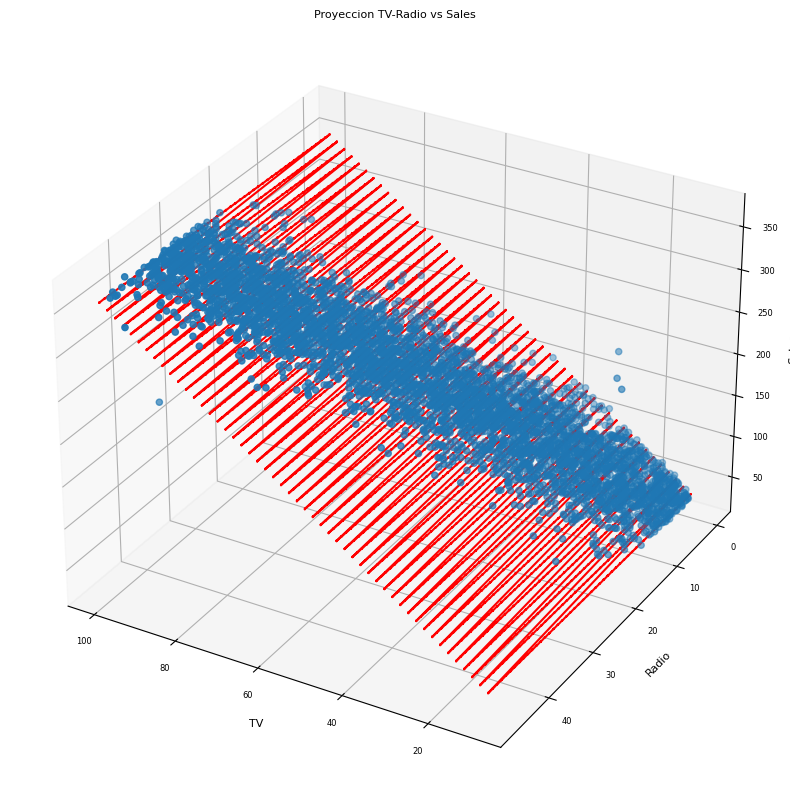

In [123]:
# Representacion proyeccion en TV, Radio, Sales

# axes = plt.axes(projection ='3d') 
fig = plt.figure(figsize=(20, 10))
axes = fig.add_subplot(111, projection='3d')

# Puntos
tv = df_marketing_sales['TV'].values.tolist()
radio = df_marketing_sales['Radio'].values.tolist()
sales = df_marketing_sales['Sales'].values.tolist()
axes.scatter(tv, radio, sales)

# Superficie proyeccion 
# sales = 0.58 + 3.51 * TV + 0.11 * Radio + 0.06 * SocialMedia + -0.10 * Influencer

partTV = np.linspace(df_marketing_sales['TV'].min(),df_marketing_sales['TV'].max())
partRadio = np.linspace(df_marketing_sales['Radio'].min(),df_marketing_sales['Radio'].max())
partMedia = np.linspace(df_marketing_sales['Social Media'].min(),df_marketing_sales['Social Media'].max())
partInfluencer = np.linspace(df_marketing_sales['Influencer'].min(),df_marketing_sales['Influencer'].max())
cartesian_product =  list(itertools.product(partTV, partRadio, partMedia, partInfluencer))
gridTV = [ e[0] for e in cartesian_product]
gridRadio = [ e[1] for e in cartesian_product]
gridMedia = [ e[2] for e in cartesian_product]
gridInfluencer = [ e[3] for e in cartesian_product]

@np.vectorize
def proyeccionTVRadio(tv, radio, media, influencer):
    return 0.58 + 3.51 * tv + 0.11 * radio + 0.06 * media - 0.10 * influencer
gridz = proyeccionTVRadio(gridTV, gridRadio, gridMedia, gridInfluencer)

axes.plot(gridTV, gridRadio, gridz, color='red')


# Ajustando grafico

axes.set_title('Proyeccion TV-Radio vs Sales', fontsize=8)
axes.set_xlabel("TV", fontsize=8)
axes.set_ylabel("Radio", fontsize=8)
axes.set_zlabel("Sales", fontsize=8)

axes.tick_params(axis='both', labelsize=6)
axes.view_init(azim=90)

# Generar gifs
for ii in np.arange(0, 360, 1):
    axes.view_init(elev=32, azim=ii)
    if ii<10:
        fig.savefig('proyeccionTVRadio/gif_image00%d.png' % ii)
    elif ii<100:
        fig.savefig('proyeccionTVRadio/gif_image0%d.png' % ii)
    else:
        fig.savefig('proyeccionTVRadio/gif_image%d.png' % ii)
# ahora hay que esperar y juntar los frames usando https://imgflip.com/gif-maker

axes.view_init(azim=120)
plt.show()


In [124]:
import glob
from PIL import Image

frames = [Image.open(image) for image in glob.glob("proyeccionTVRadio/*.png")]
frame_one = frames[0]
frame_one.save("my_awesome2.gif", format="GIF", append_images=frames,
           save_all=True, duration=100, loop=0)
    

<img src="my_awesome2.gif" height="1000" align="center">

## Random Forest Regression

In [71]:
rf = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=random_seed)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=10, random_state=54)

In [72]:
rf.predict(X_test)

array([ 92.23917064, 354.40013634, 164.00973635, ..., 205.12675331,
        39.11063179,  84.91381325])

In [73]:
# Evaluando la bondad del modelo
print("Rendimiento (R^2) sobre entrenamiento: {:.2f}".format(rf.score(X_train, y_train)))
print("Rendimiento (R^2) sobre test: {:.2f}".format(rf.score(X_test, y_test)))
scores_val = cross_val_score(rf, X, y, cv=kfold)
print("Rendimiento (R^2) sobre validacion cruzada: {:.2f}".format(scores_val.mean()))

Rendimiento (R^2) sobre entrenamiento: 1.00
Rendimiento (R^2) sobre test: 0.99
Rendimiento (R^2) sobre validacion cruzada: 0.99


In [74]:
# Otras metricas del modelo
mse = mean_squared_error(y_test, rf.predict(X_test))
rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
r2 = r2_score(y_test, rf.predict(X_test))
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2): {:.2f}".format(r2))

Mean Squared Error (MSE): 55.21
Root Mean Squared Error (RMSE): 7.43
R-squared (R2): 0.99


In [75]:
rf.feature_importances_.reshape(1,4)

array([[9.94015125e-01, 4.00060926e-03, 1.85167009e-03, 1.32596060e-04]])

In [76]:
# Importancia de los atributos
features_importance = pd.Series(data=rf.feature_importances_, 
          index=X.columns.values.tolist())
display(pd.DataFrame(features_importance, columns=["Importance"]))

,Importance
TV,0.994015
Radio,0.004001
Social Media,0.001852
Influencer,0.000133


<Axes: >

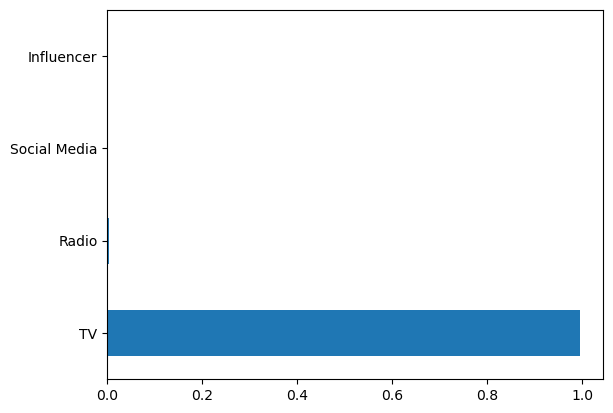

In [77]:
features_importance.plot.barh()

<Axes: >

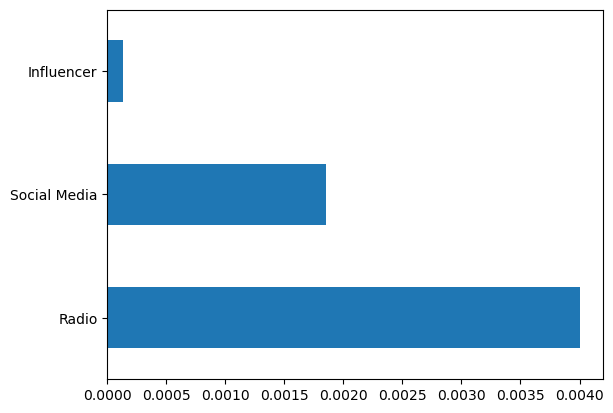

In [78]:
features_importance.drop("TV").plot.barh()

In [335]:
# Representacion ???????????????

### GridSearch

In [ ]:
# ???????????????? Lo hacemos? creo que no hace falta